# This notebook handles ingestion of stocks data to feature store

In [1]:
import mlrun
project = mlrun.get_or_create_project(name='stocks',user_project=True, context="./")

> 2022-06-14 09:20:33,408 [info] created and saved project stocks


> <b> Steps </b>
> * [Creating mlrun function that reads stocks from yahoo_fin and returning record oriented json](#Creating-mlrun-function-that-reads-stocks-from-yahoo_fin-and-returning-record-oriented-json)
> * [Creating a feature set and declaring the graph](#Creating-a-feature-set-and-declaring-the-graph)
> * [Dummy ingestion, Deploying ingestion service and getting ingestion endpoint](#Dummy-ingestion,-Deploying-ingestion-service-and-getting-ingestion-endpoint)
> * [Testing ingestion service](#Testing-ingestion-service)
> * [Creating scheduled mlrun job to invoke our function every time delta](#Creating-scheduled-mlrun-job-to-invoke-our-function-every-time-delta)

## Creating mlrun function that reads stocks from yahoo_fin and returning record oriented json
similar to ingest_stocks, we collect the data from within the feature-set graph. <br>
event sent to graph is real-time configuration.

In [2]:
import os

USER_NAME = os.environ['V3IO_USERNAME']
STREAM_SHARDS = 1 # NO. of input stream shard

In [3]:
# serving function configuration
SERVING_FUNCTION_RESPONSE = 'SYNC'
MIN_REPLICAS = 1 # serving function minimum replicas
MAX_REPLICAS = 1 # serving function maximum replicas
SERVING_PROCESSING_TIME = 1 # time for the serving function to sleep
WORKER_AVAILIBALITY_TIMEOUT = 100
INGRESS_TIMEOUT = 150
USE_GPU = False # whether the serving function will use GPU (if true - REMOTE_SCALE_RANGE will determine the consumption)

In [4]:
# RemoteStep configuration
REMOTE_STEP_WORKERS = 1
MAX_IN_FLIGHT = 1  # how many simulteneous events on each worker in the serving function
REMOTE_STEP_HTTP_TIMEOUT = 150
STOREY_QUEUE_SIZE = 8
WINDOW_ACK = (STOREY_QUEUE_SIZE+MAX_IN_FLIGHT)*STREAM_SHARDS

In [5]:
streams_prefix = "v3io:///users/"+USER_NAME+"/"
news_stream = streams_prefix + "news_stream"


In [6]:
# import nuclio
# import mlrun

# model_location = 'https://iguazio-sample-data.s3.amazonaws.com/models/model.pt'
# scaled_function = mlrun.import_function('hub://sentiment_analysis_serving')
# scaled_function.spec.min_replicas = MIN_REPLICAS
# scaled_function.spec.max_replicas = MAX_REPLICAS
# scaled_function.add_model('sentiment_analysis_model', model_path=model_location,
#                           class_name='SentimentClassifierServing')

# scaled_function.with_http(workers=REMOTE_STEP_WORKERS, gateway_timeout=INGRESS_TIMEOUT,
#                           worker_timeout=WORKER_AVAILIBALITY_TIMEOUT)

# env_vars = {"SERVING_FUNCTION_TIME_TO_SLEEP": SERVING_PROCESSING_TIME}

# scaled_function.set_envs(env_vars)
# scaled_function.spec.readiness_timeout = 300
# address = scaled_function.deploy()

In [7]:
# mlrun: start-code


# You can add your own PySpark code as a graph step:
def filter_func(df, context=None):
    return df.filter("bid>55") # PySpark code


def add_column(df, context=None):
    return_df = df.withColumn("bid_ask_diff", df.bid-df.ask)
    return return_df

def print_dataframe(df, contest=None):
    print("type of data frame {}".format(type(df)))        
    print(df.show())
    return df



In [8]:


import yahoo_fin.stock_info as si
import yahoo_fin.news as ynews
from dateutil import parser
import pandas as pd
import json
import requests
from storey import MapClass, Event
import string
import mlrun
from mlrun.feature_store.api import ingest
from IPython.display import display


def ingest_handler(context):
    ingest(mlrun_context=context) # The handler function must call ingest with the mlrun_context



def print_event(event):    
    sentiment = event.body['outputs']['predictions'][0]/2
    return_event = Event(body={'sentiment': sentiment}, key=event.body['outputs']['meta_data']['ticker'], time=event.body['outputs']['meta_data']['Datetime'])
    print(return_event)
    return return_event


def wrap_event(event):
    print(event)
    wrapped_event = {'meta_data': {'ticker': event['ticker'], 'Datetime': event['Datetime']}, 'inputs': [event['summary']]}
    print(wrapped_event)
    return wrapped_event

def remove_punctuation(text):
    punctuationfree = "".join([i for i in text if i not in string.punctuation])
    return punctuationfree


def get_news(event):
    '''
    event: dict with the following keys:
    n_stocks - how many stocks to collect
    '''
    tickers = si.tickers_sp500()[:event['n_stocks']]
    tickers_news = []
    for ticker in tickers:
        news = ynews.get_yf_rss(ticker=ticker)
        news_df = pd.DataFrame(news)
        df_copy = news_df[['title', 'summary', 'link', 'published']].copy()
        df_copy['ticker'] = ticker
        df_copy['Datetime'] = df_copy['published'].apply(lambda x: parser.parse(x).strftime('%Y-%m-%d %H:%M:%S'))
        df_copy['summary'] = df_copy['summary'].apply(lambda x: remove_punctuation(x))
        df_copy['title'] = df_copy['title'].apply(lambda x: remove_punctuation(x))
        tickers_news.append(df_copy)
    df = pd.concat(tickers_news).reset_index(drop=True)
    return json.loads(df.to_json(orient='records'))

def print_dataframe(df, contest=None):
    print("type of data frame {}".format(type(df)))        
    print(df.show())
    return df


#mlrun: end-code

## Creating a feature set and declaring the graph

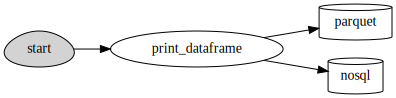

In [9]:
from mlrun.datastore.sources import CSVSource
import mlrun.feature_store as fstore
from mlrun.feature_store.steps import DateExtractor, MapValues
import yahoo_fin.stock_info as si
from mlrun.serving.remote import RemoteStep 
# creating feature set
news_set = fstore.FeatureSet("stocks_news", 
                                 entities=[fstore.Entity("ticker")],
                                 timestamp_key='Datetime', 
                                 description="stocks news feature set",engine="spark")

# how many tickers data we ingest (make sure same number used for ingesting news)
# n_tickers = 4

source = CSVSource("mycsv", path="v3io:///projects/news_input.csv")


news_set.graph \
    .to(name="print_dataframe", handler="print_dataframe")

#     .to("storey.steps.Flatten", name="flatten_news") \
#     .to(name='wrap_event', handler='wrap_event') \
#     .to(">>", "news_stream", path=news_stream,shards = STREAM_SHARDS)\
#     .to(RemoteStep(name="remote_scale", url=address, method="POST", max_in_flight=MAX_IN_FLIGHT,
#                    timeout=REMOTE_STEP_HTTP_TIMEOUT)) \
#     .to(name='print_event', handler='print_event',full_event=True)

news_set.set_targets(with_defaults=True) 
news_set.plot(rankdir="LR", with_targets=True)

## Dummy ingestion, Deploying ingestion service and getting ingestion endpoint

In [10]:
from mlrun import code_to_function
import mlrun.feature_store as fstore


my_func = code_to_function("func", kind="spark")

my_func.with_driver_requests(cpu=1, mem="1G")
my_func.with_executor_requests(cpu=1, mem="1G")
my_func.with_igz_spark()

# Enables using the default image (can be replace with specifying a specific image with .spec.image)
my_func.spec.use_default_image = True

# Not a must - default: 1
my_func.spec.replicas = 2

# If needed, sparkConf can be modified like this:
# my_func.spec.spark_conf['spark.specific.config.key'] = 'value'

config = fstore.RunConfig(local=True, function=my_func, handler="ingest_handler")
quotes_df = fstore.ingest(news_set, source, run_config=config)

> 2022-06-14 09:21:06,786 [info] starting run stocks-news-ingest uid=e89acbdb50ee4f2198b73925511d0a36 DB=http://mlrun-api:8080
> 2022-06-14 09:21:07,062 [info] starting ingestion task to store://feature-sets/stocks-avia/stocks_news:latest.
type of data frame <class 'pyspark.sql.dataframe.DataFrame'>
+--------------------+--------------------+--------------------+--------------------+------+-------------------+
|               title|             summary|                link|           published|ticker|           Datetime|
+--------------------+--------------------+--------------------+--------------------+------+-------------------+
|Agilent A to Prov...|Agilent A collabo...|https://finance.y...|Wed, 08 Jun 2022 ...|     A|2022-06-08 18:57:06|
|Agilent Leverages...|SANTA CLARA Calif...|https://finance.y...|Tue, 07 Jun 2022 ...|     A|2022-06-07 14:35:00|
|Do Agilent Techno...|Like a puppy chas...|https://finance.y...|Tue, 07 Jun 2022 ...|     A|2022-06-07 12:00:40|
|Agilent Announces...

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
stocks-avia,...511d0a36,0,Jun 14 09:21:06,completed,stocks-news-ingest,job-type=feature-ingestfeature-set=store://feature-sets/stocks-avia/stocks_newsv3io_user=aviakind=owner=aviahost=jupyter-avia-cddbfcfcd-sf4lp,,"infer_options=63overwrite=Nonefeatureset=store://feature-sets/stocks-avia/stocks_newssource={'kind': 'csv', 'name': 'mycsv', 'path': 'v3io:///projects/news_input.csv'}targets=None",,


> 2022-06-14 09:21:35,107 [info] run executed, status=completed


In [12]:
# Define the HTTP Source to_dictable the HTTP trigger on our function and expose the endpoint.
# There is an option to declare key and timestamp inside the http source (here we dont send data through the http hence not needed)
http_source = mlrun.datastore.sources.HttpSource()
news_set.spec.source = http_source

# code_to_function our mlrun wrapped function to deploy the ingestion pipeline on.
# the serving runtimes enables the deployment of our feature set's computational graph
function = mlrun.code_to_function(name='get_news',kind='serving',image='mlrun/mlrun', requirements=['yahoo_fin'])
function.spec.readiness_timeout=100000

run_config = fstore.RunConfig(function=function, local=False).apply(mlrun.mount_v3io())

In [ ]:
# Deploying
news_set_endpoint = fstore.deploy_ingestion_service(featureset=news_set, run_config=run_config)

## Testing ingestion service

In [ ]:
import requests
import json

now = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

t = requests.post(news_set_endpoint,json={'ticker':['news'],
                                                 'Datetime': now,
                                                 'n_stocks':4})
t.text

## Creating scheduled mlrun job to invoke our function every time delta

In [ ]:
os.makedirs('src',exist_ok=True)

In [ ]:
%%writefile src/invoker.py

import requests
import datetime

def ingestion_service_invoker(endpoint): 
    now = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    
    t = requests.post(endpoint,json={'ticker':['news'],
                                     'Datetime': now,
                                     'n_stocks':4})

In [ ]:
# specifying '0 8 * * *' as schedule will trigger the function every day at 08:00 AM
fn = mlrun.code_to_function(name='ingestion_service_news',kind='job',image='mlrun/mlrun',handler='ingestion_service_invoker', filename='src/invoker.py')
fn.run(params={'endpoint':news_set_endpoint}, schedule='0 8 * * *')